<a href="https://colab.research.google.com/github/nit611/The-Sparks-Foundation/blob/da_real_nit/Numerical_and_textual_analysis_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STOCK MARKET PREDICTION USING NUMERICAL AND TEXTUAL ANALYSIS** 


# Author: **Nithin Gopalakrishnan**

**Importing the library to upload documents from a local source.** 

In [ ]:
from google.colab import files
up = files.upload()

Saving RELIANCE.BO.csv to RELIANCE.BO (1).csv


I have taken Reliance Stock Prices, as Reliance is one of the biggest stocks traded in India by volume, and also, in the current political climate, one of the most relevant. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pandas.plotting import autocorrelation_plot
import nltk
from nltk.corpus import stopwords

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*Above I import all the necessary libraries to conduct the analysis*

In [ ]:
df = pd.read_csv('RELIANCE.BO.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-16,464.500000,470.899994,462.350006,466.524994,446.749115,794162.0
1,2015-11-17,468.350006,469.350006,462.975006,463.750000,444.091736,342994.0
2,2015-11-18,463.500000,465.825012,455.000000,456.174988,436.837860,459920.0
3,2015-11-19,459.750000,468.750000,459.000000,467.100006,447.299744,451980.0
4,2015-11-20,467.700012,476.049988,462.700012,472.975006,452.925720,607934.0


Making a copy to the dataset is always a good practice to do, since it gives us the freedom of reverting back to the original data, whenever needed.

In [ ]:
rel = df.copy()

In [ ]:
rel.drop(['Open','High','Low','Adj Close','Volume'], 1, inplace = True)

In [ ]:
rel['Date'] = pd.to_datetime(rel['Date'])

**Let the cleaning begin!** \
I deleted all the unnecessary columns, and kept just the date and the closing prices columns.

In [ ]:
print(rel.head())
print(rel.info())

        Date       Close
0 2015-11-16  466.524994
1 2015-11-17  463.750000
2 2015-11-18  456.174988
3 2015-11-19  467.100006
4 2015-11-20  472.975006
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1234 non-null   datetime64[ns]
 1   Close   1233 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.4 KB
None


In [ ]:
# For analysis purposes, lets convert closing prices to log closing prices
rel['Close'] = np.log(rel['Close'])

In [ ]:
rel.head()

,Date,Close
0,2015-11-16,6.145312
1,2015-11-17,6.139346
2,2015-11-18,6.122876
3,2015-11-19,6.146543
4,2015-11-20,6.159043


Now for some visualization. Most stock prices contain a trend. And since stock prices are not "predictable" in the short term sense, they are what is called as a "random-walk process" in Time Series Analysis. Random walk processes mean that there is no stationarity. And this means that the stock prices have varying mean values at different points in time. 

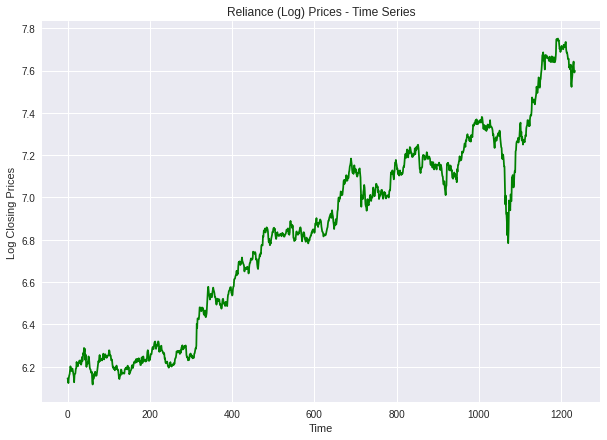

In [ ]:
rel.dropna(inplace = True)
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
rel['Close'].plot(color='g')
plt.title('Reliance (Log) Prices - Time Series')
plt.ylabel('Log Closing Prices')
plt.xlabel('Time')
plt.show()

In [ ]:
# Add column to find returns of Reliance
rel['Returns'] = rel['Close'].diff()

In [ ]:
rel.head()

,Date,Close,Returns
0,2015-11-16,6.145312,NaN
1,2015-11-17,6.139346,-0.005966
2,2015-11-18,6.122876,-0.016469
3,2015-11-19,6.146543,0.023667
4,2015-11-20,6.159043,0.012499


In [ ]:
rel.dropna(inplace = True)

The graph below is a classic example of how returns of a stock can be volatile when the times are turbulent. 2020 has seen one of the world's worst external shock - the coronavirus pandemic. The stock prices in an emerging country like India, already see high risk-high reward. The graph below shows the turbulence.

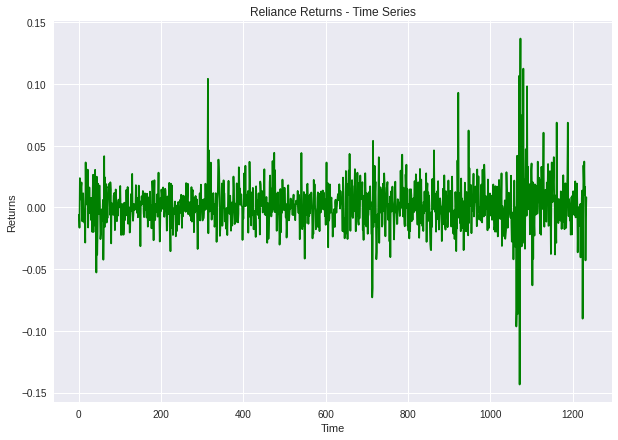

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
rel['Returns'].plot(color='g')
plt.title('Reliance Returns - Time Series')
plt.ylabel('Returns')
plt.xlabel('Time')
plt.show()

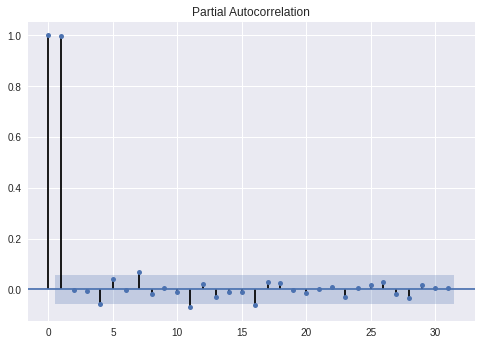

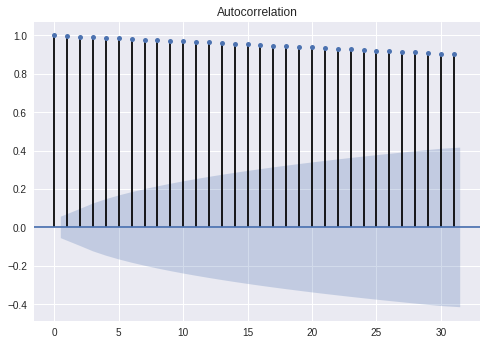

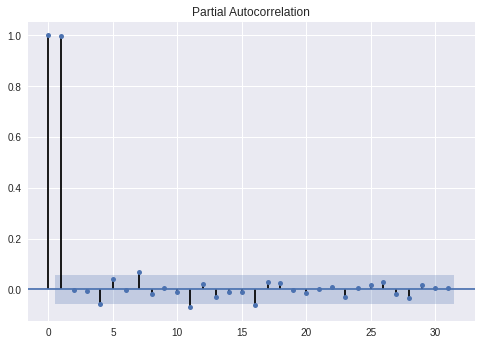

In [ ]:
# The series is obviously not stationary (the returns, as well as the log closing prices). Let us check the ACF and PACF for the log prices
plot_acf(rel['Close'])
plot_pacf(rel['Close'])

One of the direct measures of stationarity is the Autocorrelation and the Partial Autocorrelation function. If the autocorrelation graph exhibits a slowly "decaying" function, while the Partial ACF exhibits one large spike (after the first spike), it typically is an AR(1) process, and non-stationary.

In [43]:
# Slowly decaying Autocorrelation function indicates non-stationarity/ two spiked Partial ACF indicates that the function has an
# Autoregressive parameter (AR) 1. So, the function is an AR(1) process.
# Notice how in the previous graph, the returns function exhibited a sort of an increasing variance. We may need to model it as an ARCH-GARCH function too.

Below is the formal Augmented Dickey-Fuller Stationarity test to determine the stationarity of the log closing prices of Reliance stock.

In [ ]:
# Stationarity test - The Augmented Dickey Fuller test
def stationarity_test(series):
  
  print('The Results for Stationarity of the Series')
  result = adfuller(series)
  labels = ['The ADF Statistic', 'p-Value', 'Number of lags used', 'Number of observations']
  for value, key in zip(result, labels):
    print(key + ' : ' + str(value))
  if result[1] <= 0.05:
    print('The ADF test shows that we can reject the null hypothesis that the series contains a unit root, and that the series is Stationary.')
  else:
    print('The ADF test shows that we cannot reject the null hypothesis that the series contains a unit root, and that the series is non-stationary.')

In [ ]:
stationarity_test(rel['Close'])

The Results for Stationarity of the Series
The ADF Statistic : -0.5480194797234336
p-Value : 0.8823003416994148
Number of lags used : 7
Number of observations : 1224
The ADF test shows that we cannot reject the null hypothesis that the series contains a unit root, and that the series is non-stationary.


In [ ]:
stationarity_test(rel['Returns'])

The Results for Stationarity of the Series
The ADF Statistic : -12.92935510853685
p-Value : 3.72891403949426e-24
Number of lags used : 6
Number of observations : 1225
The ADF test shows that we can reject the null hypothesis that the series contains a unit root, and that the series is Stationary.


In [ ]:
# The Closing prices is integrated of order 1. 

In [ ]:
plot_acf(rel['Returns'])
plot_pacf(rel['Returns'])

In [ ]:
import pmdarima

In [ ]:
from pmdarima import auto_arima

The beneficial aspect of the Auto ARIMA package in python is that, it picks the order of ARIMA by itself, along with the estimation. \
The ARIMA model for a univariate time series consists of three components - the AR component, the I component and the MA component. The AR or Autoregressive component indicates how far behind is the stock prices dependent on itself? The I component asks how many times does a series need to be differentiated to get stationary? and the MA component checks the dependence of the series on past residuals.

In [ ]:
len(rel['Close'])

1232

In [ ]:
train = rel['Close'][:900]
test = rel['Close'][900:]

In [ ]:
model = auto_arima(train, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4969.392, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4967.594, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4969.992, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4969.622, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4964.659, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4969.613, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4968.448, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4967.610, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4967.734, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.272 seconds


It seems than an ARIMA (1,1,0) model is optimal.

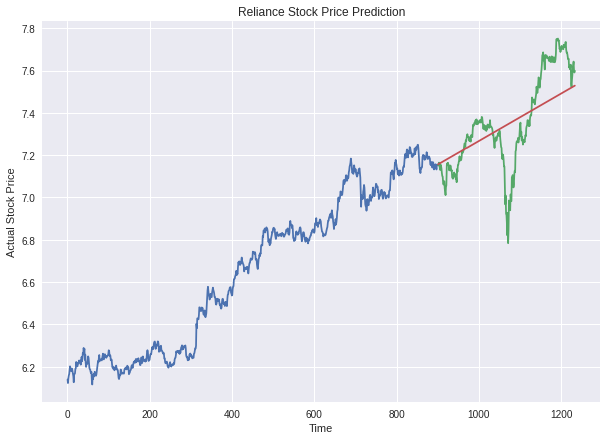

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.show()

The red line in the above graph shows a "mean value" for the sample that is green (the out of sample testing set).

In [ ]:
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(test , predictions))
print("RMSE : ", rms)

RMSE :  0.15399477241794934


The insignificance of the ARIMA component in the summary output below indicates that there might be a problem with the modelling. Even if the Auto ARIMA model picked up the optimal order, there is one component missing. Check below to find out what.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1231
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3126.448
Method:                       css-mle   S.D. of innovations              0.019
Date:                Mon, 16 Nov 2020   AIC                          -6246.897
Time:                        14:10:42   BIC                          -6231.550
Sample:                             1   HQIC                         -6241.123
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      2.220      0.026       0.000       0.002
ar.L1.D.Close    -0.0184      0.028     -0.646      0.518      -0.074       0.037
                                    Root

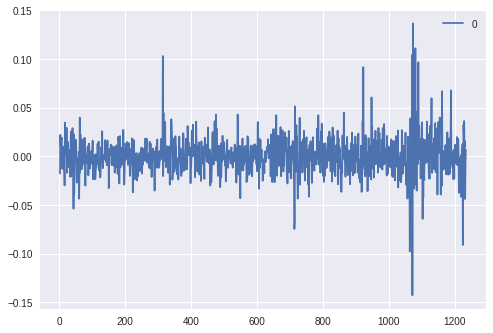

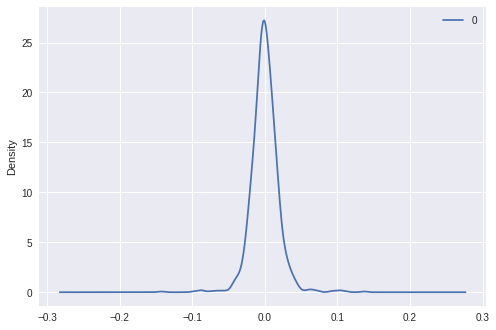

                  0
count  1.231000e+03
mean  -2.621461e-07
std    1.909564e-02
min   -1.427135e-01
25%   -9.866428e-03
50%   -3.250709e-04
75%    9.713134e-03
max    1.366873e-01


In [ ]:
mod = ARIMA(rel['Close'],(1,1,0))
mod_fit = mod.fit(display = 0)
print(mod_fit.summary())
residual = pd.DataFrame(mod_fit.resid)
residual.plot()
plt.show()
residual.plot(kind = 'kde')
plt.show()
print(residual.describe())

The residual plot (the first graph) shows increasing volatility. There is presence of volatility clustering, and there is a need to model using Autoregressive Conditional Heteroskedasticity, or ARCH. \
ARCH allows us to model non-constant variance of the residual, while capturing the ARIMA component of the time series.

In [ ]:
news = files.upload()

Saving india-news-headlines.csv to india-news-headlines (1).csv


Now, for the Textual Analysis

In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
ps = PorterStemmer()

**Data Cleaning**

In [ ]:
df_news = pd.read_csv('india-news-headlines.csv', names = cols)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_news.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


In [ ]:
df_news.drop(0, inplace = True)

In [ ]:
df_news.drop('Category', axis = 1, inplace = True)

In [ ]:
df_news

,Date,News
1,20010101,win over cena satisfying but defeating underta...
2,20010102,Status quo will not be disturbed at Ayodhya; s...
3,20010102,Fissures in Hurriyat over Pak visit
4,20010102,America's unwanted heading for India?
5,20010102,For bigwigs; it is destination Goa
...,...,...
3297168,20200630,why tiktok removed 1 65 crore videos in india
3297169,20200630,apurva asrani calls alia bhatts mother soni ra...
3297170,20200630,kangana ranaut gets a doll version of herself ...
3297171,20200630,meezaan jaffrey reminisces his childhood days ...


In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 75.5+ MB


In [ ]:
df_news['Date'] = pd.to_datetime(df_news['Date'], format = '%Y%m%d')
df_news

,Date,News
1,2001-01-01,win over cena satisfying but defeating underta...
2,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
3,2001-01-02,Fissures in Hurriyat over Pak visit
4,2001-01-02,America's unwanted heading for India?
5,2001-01-02,For bigwigs; it is destination Goa
...,...,...
3297168,2020-06-30,why tiktok removed 1 65 crore videos in india
3297169,2020-06-30,apurva asrani calls alia bhatts mother soni ra...
3297170,2020-06-30,kangana ranaut gets a doll version of herself ...
3297171,2020-06-30,meezaan jaffrey reminisces his childhood days ...


In [ ]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x: ' '.join(x))
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,Powerless north India gropes in the dark Think...
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...
7076,2020-06-27,like me i wont let you have a toxic relationsh...
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [ ]:
df_news['News']

0       win over cena satisfying but defeating underta...
1       Status quo will not be disturbed at Ayodhya; s...
2       Powerless north India gropes in the dark Think...
3       The string that pulled Stephen Hawking to Indi...
4       Light combat craft takes India into club class...
                              ...                        
7075    Containment zone residents slam high prices ch...
7076    like me i wont let you have a toxic relationsh...
7077    Atanu Ghosh plans to rewrite old scripts to ma...
7078    6 hot and stylish bikini looks of Katrina Kaif...
7079    Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
Name: News, Length: 7080, dtype: object

In [ ]:
ch = []
for i in range(0, len(df_news['News'])):
  news = re.sub('[^a-zA-Z]', ' ', df_news['News'][i])
  news = news.lower()
  news = news.split()
  news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
  news=' '.join(news)
  ch.append(news)

In [ ]:
df_news['News'] = pd.Series(ch)
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,News
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
2,2001-01-03,powerless north india grope dark think laxman ...
3,2001-01-04,string pull stephen hawk india vajpaye give bi...
4,2001-01-05,light combat craft take india club class hawk ...
...,...,...
7075,2020-06-26,contain zone resid slam high price charg veget...
7076,2020-06-27,like wont let toxic relationship food major ra...
7077,2020-06-28,atanu ghosh plan rewrit old script make relev ...
7078,2020-06-29,hot stylish bikini look katrina kaif anna eden...


In [ ]:
def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
df_news['Subjectivity'] = df_news['News'].apply(get_subjectivity)
df_news['Polarity'] = df_news['News'].apply(get_polarity)
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,News,Subjectivity,Polarity
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
...,...,...,...,...
7075,2020-06-26,contain zone resid slam high price charg veget...,0.330257,0.066958
7076,2020-06-27,like wont let toxic relationship food major ra...,0.372264,0.064784
7077,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.378165,0.054209
7078,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782


While subjectivity captures how opinionated the headline is, polarity captures the nature of the sentiment of the headline (positive or negative).

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7080 non-null   datetime64[ns]
 1   News          7080 non-null   object        
 2   Subjectivity  7080 non-null   float64       
 3   Polarity      7080 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 221.4+ KB


In [ ]:
intense = SentimentIntensityAnalyzer()

Using the VADER polarity scores, we can obtain the positive, negative and neutrality scores for the headlines, and a compound, which is an aggregate measure of it all.

In [ ]:
df_news['Compound'] = [intense.polarity_scores(a)['compound'] for a in df_news['News']]
df_news['Negative'] = [intense.polarity_scores(a)['neg'] for a in df_news['News']]
df_news['Neutral'] = [intense.polarity_scores(a)['neu'] for a in df_news['News']]
df_news['Positive'] = [intense.polarity_scores(a)['pos'] for a in df_news['News']]
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000,0.2023,0.234,0.469,0.297
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
...,...,...,...,...,...,...,...,...
7075,2020-06-26,contain zone resid slam high price charg veget...,0.330257,0.066958,-0.9998,0.142,0.789,0.069
7076,2020-06-27,like wont let toxic relationship food major ra...,0.372264,0.064784,-0.9998,0.139,0.790,0.070
7077,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.378165,0.054209,-0.9998,0.136,0.800,0.064
7078,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782,-0.9998,0.130,0.800,0.070


Merging the Stock prices dataset with the news headline dataset along with NLTK's polarity scores, in order to predict stock prices using the changes in the sentiment

In [ ]:
df_merged = pd.merge(rel, df_news, how = 'inner', on = 'Date')
df_merged

,Date,Close,Returns,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-11-17,6.139346,-0.005966,healthi fridg quiz curiou case bollywood name ...,0.414518,0.061043,-0.9997,0.138,0.767,0.095
1,2015-11-18,6.122876,-0.016469,talk celebr divorc isl kolkata vs chennai free...,0.367319,0.056717,-0.9999,0.162,0.750,0.088
2,2015-11-19,6.146543,0.023667,intern men day thing men perfect indian spice ...,0.407112,0.121935,-0.9994,0.131,0.768,0.101
3,2015-11-20,6.159043,0.012499,food item keep away toddler eat curd night wor...,0.399060,0.116634,-0.9980,0.115,0.788,0.097
4,2015-11-23,6.165523,0.006480,herb battl diabet thing know sleep aamir khan ...,0.418888,0.104645,-0.9969,0.118,0.775,0.107
...,...,...,...,...,...,...,...,...,...,...
1130,2020-06-24,7.454344,0.004235,never thought voic today vidya rajput never th...,0.368654,0.077799,-0.9997,0.126,0.807,0.067
1131,2020-06-25,7.448887,-0.005457,truck firm look new export market sell bs rang...,0.362784,0.011935,-0.9999,0.153,0.795,0.052
1132,2020-06-26,7.463134,0.014247,contain zone resid slam high price charg veget...,0.330257,0.066958,-0.9998,0.142,0.789,0.069
1133,2020-06-29,7.451909,-0.011224,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782,-0.9998,0.130,0.800,0.070


In [ ]:
df_merged.to_csv('main_file.csv')

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
df_merged.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [7]:
df_merged = pd.read_csv('drive/My Drive/Main_TSF.csv')

In [8]:
df_merged.head()

,Unnamed: 0,Date,Close,Returns,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0,2015-11-17,6.139346,-0.005966,healthi fridg quiz curiou case bollywood name ...,0.414518,0.061043,-0.9997,0.138,0.767,0.095
1,1,2015-11-18,6.122876,-0.016469,talk celebr divorc isl kolkata vs chennai free...,0.367319,0.056717,-0.9999,0.162,0.750,0.088
2,2,2015-11-19,6.146543,0.023667,intern men day thing men perfect indian spice ...,0.407112,0.121935,-0.9994,0.131,0.768,0.101
3,3,2015-11-20,6.159043,0.012499,food item keep away toddler eat curd night wor...,0.399060,0.116634,-0.9980,0.115,0.788,0.097
4,4,2015-11-23,6.165523,0.006480,herb battl diabet thing know sleep aamir khan ...,0.418888,0.104645,-0.9969,0.118,0.775,0.107


In [9]:
df_merged.drop('Unnamed: 0', 1, inplace = True)
df_merged

,Date,Close,Returns,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-11-17,6.139346,-0.005966,healthi fridg quiz curiou case bollywood name ...,0.414518,0.061043,-0.9997,0.138,0.767,0.095
1,2015-11-18,6.122876,-0.016469,talk celebr divorc isl kolkata vs chennai free...,0.367319,0.056717,-0.9999,0.162,0.750,0.088
2,2015-11-19,6.146543,0.023667,intern men day thing men perfect indian spice ...,0.407112,0.121935,-0.9994,0.131,0.768,0.101
3,2015-11-20,6.159043,0.012499,food item keep away toddler eat curd night wor...,0.399060,0.116634,-0.9980,0.115,0.788,0.097
4,2015-11-23,6.165523,0.006480,herb battl diabet thing know sleep aamir khan ...,0.418888,0.104645,-0.9969,0.118,0.775,0.107
...,...,...,...,...,...,...,...,...,...,...
1130,2020-06-24,7.454344,0.004235,never thought voic today vidya rajput never th...,0.368654,0.077799,-0.9997,0.126,0.807,0.067
1131,2020-06-25,7.448887,-0.005457,truck firm look new export market sell bs rang...,0.362784,0.011935,-0.9999,0.153,0.795,0.052
1132,2020-06-26,7.463134,0.014247,contain zone resid slam high price charg veget...,0.330257,0.066958,-0.9998,0.142,0.789,0.069
1133,2020-06-29,7.451909,-0.011224,hot stylish bikini look katrina kaif anna eden...,0.373210,0.060782,-0.9998,0.130,0.800,0.070


### **Histogram Plots of the sentiments**

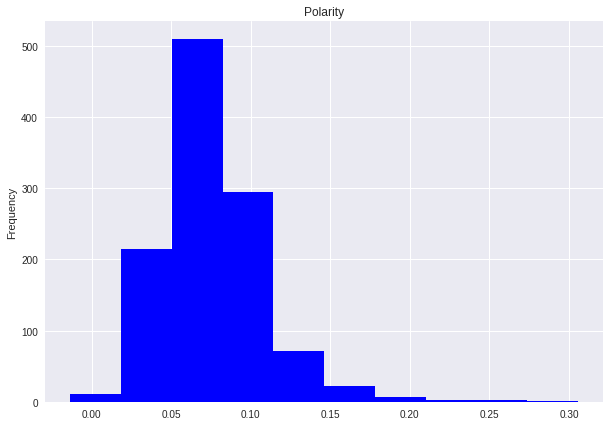

In [45]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
df_merged['Polarity'].plot(kind = 'hist', color = 'b')
plt.title('Polarity')
plt.show()

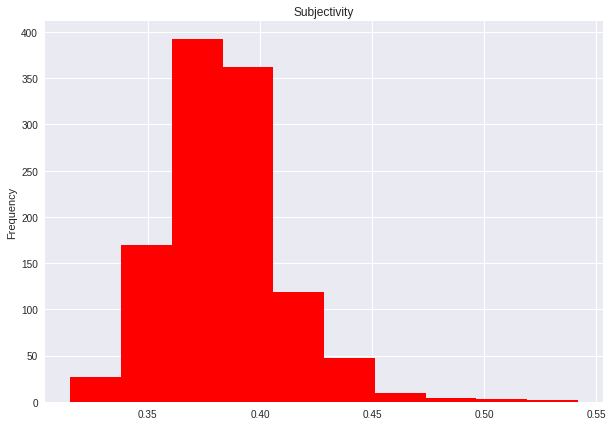

In [46]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
df_merged['Subjectivity'].plot(kind = 'hist', color = 'r')
plt.title('Subjectivity')
plt.show()

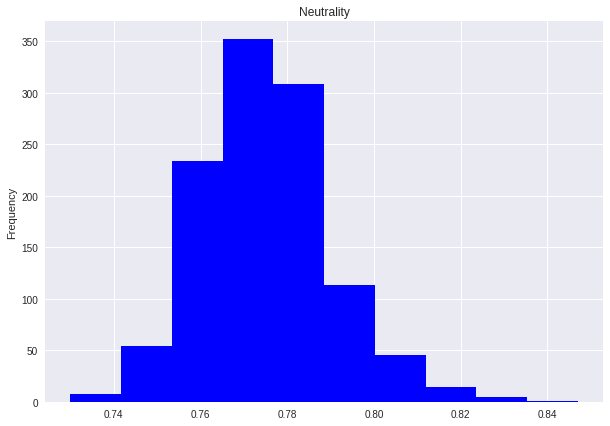

In [47]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
df_merged['Neutral'].plot(kind = 'hist', color = 'b')
plt.title('Neutrality')
plt.show()

In [21]:
df = df_merged[['Close','Subjectivity','Polarity','Neutral','Positive','Negative','Compound']]
df

,Close,Subjectivity,Polarity,Neutral,Positive,Negative,Compound
0,6.139346,0.414518,0.061043,0.767,0.095,0.138,-0.9997
1,6.122876,0.367319,0.056717,0.750,0.088,0.162,-0.9999
2,6.146543,0.407112,0.121935,0.768,0.101,0.131,-0.9994
3,6.159043,0.399060,0.116634,0.788,0.097,0.115,-0.9980
4,6.165523,0.418888,0.104645,0.775,0.107,0.118,-0.9969
...,...,...,...,...,...,...,...
1130,7.454344,0.368654,0.077799,0.807,0.067,0.126,-0.9997
1131,7.448887,0.362784,0.011935,0.795,0.052,0.153,-0.9999
1132,7.463134,0.330257,0.066958,0.789,0.069,0.142,-0.9998
1133,7.451909,0.373210,0.060782,0.800,0.070,0.130,-0.9998


In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()
sentiment = pd.DataFrame(scaler.fit_transform(df))
sentiment.columns = df.columns
sentiment.index = df.index
sentiment.head()

,Close,Subjectivity,Polarity,Neutral,Positive,Negative,Compound
0,0.017045,0.437751,0.233305,0.316239,0.5875,0.509804,0.000151
1,0.004905,0.229259,0.219733,0.170940,0.5000,0.745098,0.000050
2,0.022351,0.405037,0.424327,0.324786,0.6625,0.441176,0.000301
3,0.031565,0.369469,0.407696,0.495726,0.6125,0.284314,0.001003
4,0.036342,0.457058,0.370085,0.384615,0.7375,0.313725,0.001555


In [24]:
X = sentiment.drop('Close', 1)
y = sentiment['Close']

In [25]:
print(X.head())
print(y.head())

   Subjectivity  Polarity   Neutral  Positive  Negative  Compound
0      0.437751  0.233305  0.316239    0.5875  0.509804  0.000151
1      0.229259  0.219733  0.170940    0.5000  0.745098  0.000050
2      0.405037  0.424327  0.324786    0.6625  0.441176  0.000301
3      0.369469  0.407696  0.495726    0.6125  0.284314  0.001003
4      0.457058  0.370085  0.384615    0.7375  0.313725  0.001555
0    0.017045
1    0.004905
2    0.022351
3    0.031565
4    0.036342
Name: Close, dtype: float64


### **Split the data into training and testing**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [27]:
X_train.shape

(908, 6)

In [28]:
y_train.shape

(908,)

In [29]:
X_test.shape

(227, 6)

In [30]:
X_train[:40]

,Subjectivity,Polarity,Neutral,Positive,Negative,Compound
12,0.558682,0.309243,0.504274,0.6625,0.235294,0.003863
381,0.364782,0.280786,0.162393,0.7500,0.558824,0.000151
717,0.328143,0.281825,0.495726,0.3000,0.529412,0.000050
497,0.216516,0.281077,0.264957,0.4000,0.715686,0.000050
967,0.590373,0.526941,0.598291,0.3375,0.382353,0.000151
538,0.454200,0.285979,0.401709,0.4125,0.549020,0.000050
724,0.430556,0.248813,0.410256,0.3500,0.578431,0.000050
984,0.295002,0.293188,0.452991,0.4000,0.500000,0.000100
787,0.157880,0.364884,0.393162,0.3875,0.588235,0.000100
184,0.300009,0.336804,0.444444,0.5875,0.362745,0.000251


### **Random Forest Regressor**

In [31]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
pred = forest.predict(X_test)

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
print(pred[:10])
print(y_test[:10])
print(mean_squared_error(pred , y_test))

[0.83524812 0.61430105 0.37140829 0.50374513 0.62821154 0.14288293
 0.38061228 0.101252   0.72608299 0.78391954]
784     0.707335
900     0.765804
413     0.385388
467     0.446796
746     0.660148
109     0.059548
522     0.523859
56      0.043661
1014    0.899547
964     0.839530
Name: Close, dtype: float64
0.05873691349348416


### **ADABoost Regressor**

In [35]:
adb = AdaBoostRegressor()
adb.fit(X_train, y_train)
predict = adb.predict(X_test)
print(mean_squared_error(predict, y_test))

0.06252225272626166


In [36]:
from sklearn.tree import DecisionTreeRegressor

### **Decision Tree Regressor**

In [37]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)

In [38]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions, y_test))

[0.91866932 0.13503662 0.53638055 0.54189975 0.08567603 0.02227183
 0.08211924 0.09570894 0.92182042 0.81836865]
784     0.707335
900     0.765804
413     0.385388
467     0.446796
746     0.660148
109     0.059548
522     0.523859
56      0.043661
1014    0.899547
964     0.839530
Name: Close, dtype: float64
0.12360482456908906


### **Light Gradient Boosting Machine**

In [39]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
predictions = lgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

0.06171522600163958


### **Extreme Gradient Boosting**

In [41]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)

[09:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [42]:
predictions = xgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

0.059354692475989665


### **Linear Regression**

In [44]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)
pred = lin.predict(X_test)
print(mean_squared_error(pred, y_test))

0.06417639677685077


**Random Forest Regressor seems to work the best, among all the other regressors.** \
Even though XGBoost is known for faster and better model performance. 